# Import Library

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Import Image
Bisa lewat google drive atau local file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
import os

uploaded = files.upload()

Saving gangsta.JPEG to gangsta.JPEG
Saving itam.JPEG to itam.JPEG


In [ ]:
img_original = cv2.imread("gangsta.JPEG")
img_gelap = cv2.imread("itam.JPEG")

img_original = cv2.resize(img_original, (920, 512))
img_gelap = cv2.resize(img_gelap, (920, 512))

# Fungsi Night Vision

In [ ]:
# ========== Gamma Correction
def adjust_gamma(image, gamma=2.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
    return table[image]

# ========== Grayscale
def to_grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

# ========== Histogram Equalization
def histo_equal(gray):
    hist, _ = np.histogram(gray.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = 255 * (cdf - cdf.min()) / (cdf.max() - cdf.min())
    return cdf_normalized[gray.astype(np.uint8)]

# ========== Gaussian Blur
def gaussian_blur(image):
    kernel = (1/16) * np.array([[1,2,1], [2,4,2], [1,2,1]])
    return apply_kernel(image, kernel)

# ========== Apply Kernel
def apply_kernel(image, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(image, pad, mode='reflect')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)
    return np.clip(output, 0, 255).astype(np.uint8)

# ========== Sobel Edge Detection
def sobel_edge(gray, threshold=100):
    gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    grad_x = apply_kernel(gray, gx)
    grad_y = apply_kernel(gray, gy)
    magnitude = np.sqrt(grad_x.astype(np.float32)**2 + grad_y.astype(np.float32)**2)
    return (magnitude > threshold).astype(np.uint8) * 255

# ========== Night Vision
def night_vision_effect(gray, edges, alpha=1.5):
    bright_green = np.clip(gray * alpha, 0, 255).astype(np.uint8)
    result = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)

    # Warna dasar night vision
    result[..., 1] = bright_green  # channel hijau

    # Warna edge: kuning kemerahan
    edge_color = [255, 180, 50]  # (R, G, B)
    result[edges == 255] = edge_color

    return result

# Output

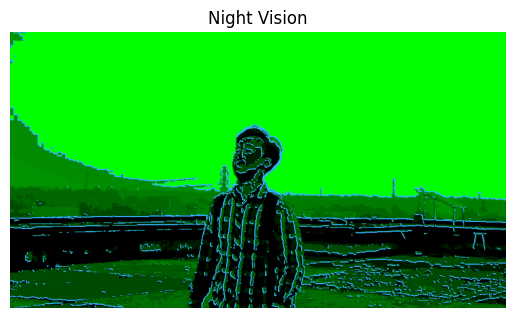

In [ ]:
# def night_vision(img):
img_gamma = adjust_gamma(img_gelap, gamma=2.0)
gray = to_grayscale(img_gamma)
enhanced = histo_equal(gray)
edges = sobel_edge(enhanced, threshold=100).astype(np.uint8)
nv_result = night_vision_effect(enhanced, edges)

plt.imshow(cv2.cvtColor(nv_result, cv2.COLOR_BGR2RGB))
plt.title("Night Vision")
plt.axis("off")
plt.show()

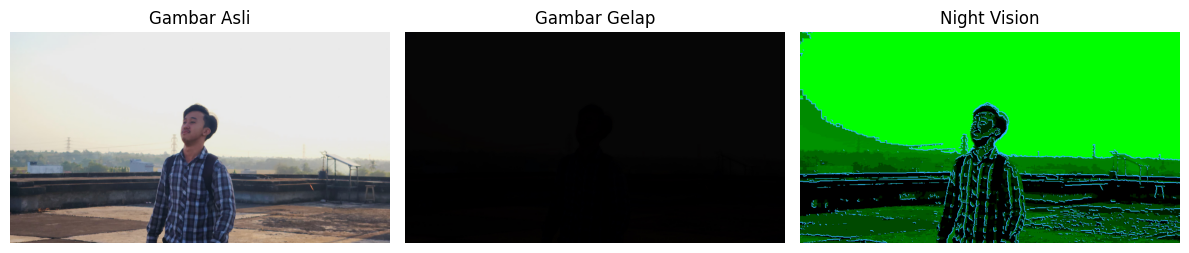

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)), plt.title("Gambar Asli"), plt.axis("off")
plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(img_gelap, cv2.COLOR_BGR2RGB)), plt.title("Gambar Gelap"), plt.axis("off")
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(nv_result, cv2.COLOR_BGR2RGB)), plt.title("Night Vision"), plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def compare_images(reference, result, title="Comparison"):
    # Resize jika ukuran tidak cocok
    result_resized = cv2.resize(result, (reference.shape[1], reference.shape[0]))

    # Convert to grayscale untuk SSIM & MSE
    ref_gray = to_grayscale(reference)
    res_gray = to_grayscale(result_resized)

    # Hitung MSE & SSIM
    mse_val = mean_squared_error(ref_gray.flatten(), res_gray.flatten())
    ssim_val = ssim(ref_gray, res_gray)

    # Tampilkan perbandingan visual dan statistik
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].imshow(cv2.cvtColor(reference, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title("Gambar Asli (Original)")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(cv2.cvtColor(result_resized, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Night Vision")
    axs[0, 1].axis("off")

    axs[1, 0].hist(reference.ravel(), bins=256, color='gray', alpha=0.7, label='Original')
    axs[1, 0].hist(result_resized.ravel(), bins=256, color='green', alpha=0.5, label='Night Vision')
    axs[1, 0].set_title("Histogram Intensitas Piksel")
    axs[1, 0].legend()

    axs[1, 1].text(0.1, 0.6, f"MSE (Mean Squared Error): {mse_val:.2f}", fontsize=14)
    axs[1, 1].text(0.1, 0.4, f"SSIM (Structural Similarity Index): {ssim_val:.4f}", fontsize=14)
    axs[1, 1].axis('off')
    axs[1, 1].set_title("Perbandingan Kuantitatif")

    plt.tight_layout()
    plt.show()

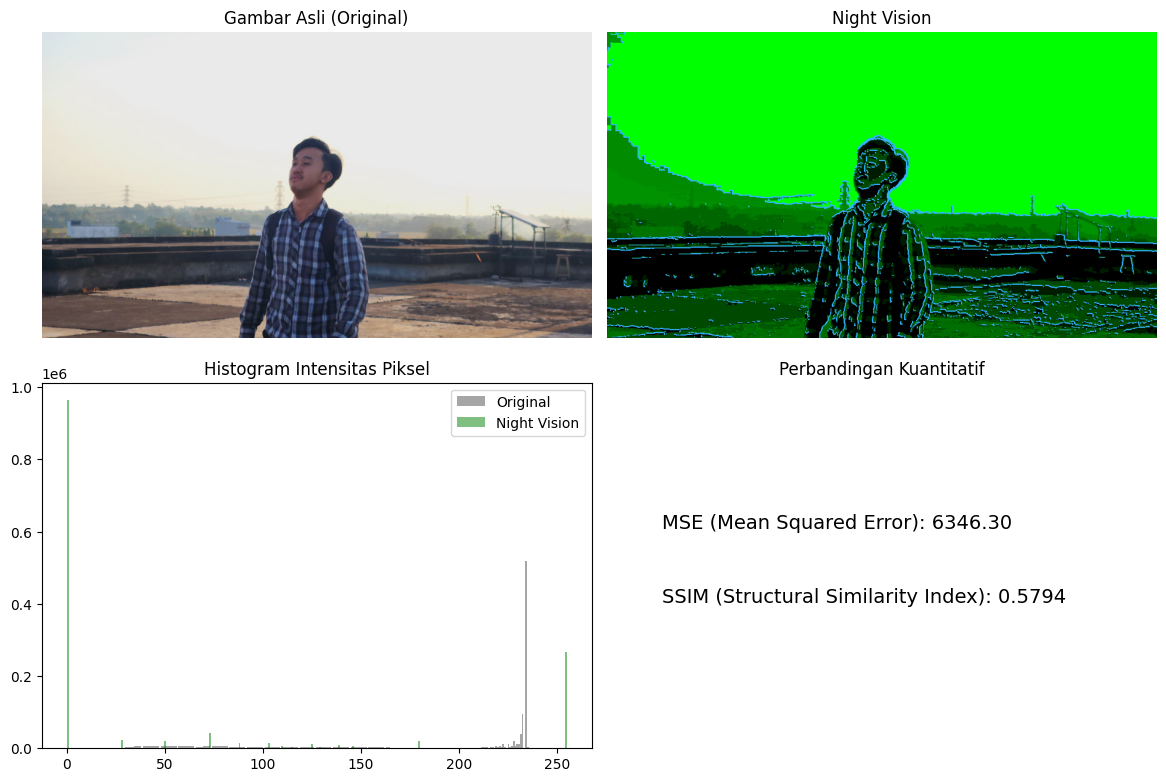

In [ ]:
compare_images(img_original, nv_result, title="Perbandingan Night Vision dengan Gambar Asli")